In [100]:
class node:
    '''
    This is the main node class of the decision tree
    This class contains the skeleton of the structure 
    of each node in the decision tree. 
    '''

    def __init__(self, attr, val, mean, mse):
        '''
        This function is the constructor to initialize the 
        values in the node object.
        Parameters
        ----------
        attr: [String] the decision attribute that has been selected 
                for this node on the basis of which the 
                children will be decided
        val: [Float] the value of the selected attribute on the 
                basis which the splitting of the children 
                nodes will be decided for the current node
        mean: [Float] mean of the attributes ( selected in the current 
                level ) of the training data, this will help in 
                making predictions at this node if it is a leaf
        mse: [Float] mean squared error of the attributes ( selected in the 
                current level ) of the training data, this will help 
                in making decisions for pruning
        '''
        self.attr = attr
        self.split = val
        self.mse = mse
        self.mean = mean
        self.left = None
        self.right = None

    def remove_children(self):
        '''
        This function is a helper function for the pruning step
        the following function removes the children of the current node
        '''
        self.right = None
        self.left = None
        self.attr = 'y'

    def restore(self, attr, left, right):
        '''
        This function will restore the  children nodes of the current 
        node during the pruning process if you decide not to remove 
        the cchildren of the current node 
        '''
        self.attr = attr
        self.left = left
        self.right = right

    def count_node(self):
        '''
        This function is a helper funcction which is used to recursively 
        count the number of nodes in the tree rooted at the given node 
        '''
        num_nodes = 1
        if self.left != None:
            num_nodes += self.left.count_node()
        if self.right != None:
            num_nodes += self.right.count_node()
        return num_nodes

    def prune(self, decision_tree_root, cur_error, X_valid):
        '''
        This function is the main pruning function. This function 
        will first recursively prune the children of the current node
        then will decide whether to prune the correct node or not 
        '''
        if self.left == None and self.right == None:
            return 10**18
        if self.left != None:
            self.left.prune(decision_tree_root, cur_error, X_valid)
        if self.right != None:
            self.right.prune(decision_tree_root, cur_error, X_valid)

        cur_error, _ = predict(decision_tree_root, X_valid)

        # store the data of the children nodes in temporary variable
        temp_left = self.left
        temp_right = self.right
        temp_attr = self.attr
        self.remove_children()

        # calculate the error on the new decision tree
        err, _ = predict(decision_tree_root, X_valid)

        # print(err, cur_error)

        # if the error on the new decision tree increases then
        # restore the children of the current node
        if err > cur_error or decision_tree_root.count_node() <= 5:
            self.restore(temp_attr, temp_left, temp_right)



def construct_tree_gini(samples, current_height, max_height, attr_list):
    '''
    This function is the main function the handles the construction 
    of the entire decision tree handling all the steps. This function 
    implements the ID3 algorithm with the help of the  functions 
    '''

    # if the max height is reached then return
    if current_height == max_height or len(samples) == 0:
        return None

    # if we have one data only then store it in the node and
    # consider this as the prediction alue for this node also
    if len(samples) == 1:
        return node('y', samples[0]['y'], samples[0]['y'], 0)

    # select the best attribute to be selected for this node
    # with the help of the functions
    attr, split, mse = good_attr_gini(samples, attr_list)
    samples1, samples2, mean = [], [], 0

    for i in samples:
        mean += i['y']
        if i[attr] <= split:
            samples1.append(i)
        else:
            samples2.append(i)

    # consider the mean as the prediction for the current node
    mean /= len(samples)

    # recursively build the left and the right children of
    # the current node and the return this node as the head
    head = node(attr, split, mean, mse)
    head.left = construct_tree_gini(
        samples1, current_height+1, max_height, attr_list)
    head.right = construct_tree_gini(
        samples2, current_height+1, max_height, attr_list)
    if head.left == None and head.right == None:
        head.attr = 'y'
        head.split = head.mean

    return head

def construct_tree_infogain(samples, current_height, max_height, attr_list):
    '''
    This function is the main function the handles the construction 
    of the entire decision tree handling all the steps. This function 
    implements the ID3 algorithm with the help of the  functions 
    '''

    # if the max height is reached then return
    if current_height == max_height or len(samples) == 0:
        return None

    # if we have one data only then store it in the node and
    # consider this as the prediction alue for this node also
    if len(samples) == 1:
        return node('y', samples[0]['y'], samples[0]['y'], 0)

    # select the best attribute to be selected for this node
    # with the help of the functions
    attr, split, mse = good_attr_infogain(samples, attr_list)
    samples1, samples2, mean = [], [], 0

    for i in samples:
        mean += i['y']
        if i[attr] <= split:
            samples1.append(i)
        else:
            samples2.append(i)

    # consider the mean as the prediction for the current node
    mean /= len(samples)

    # recursively build the left and the right children of
    # the current node and the return this node as the head
    head = node(attr, split, mean, mse)
    head.left = construct_tree_infogain(
        samples1, current_height+1, max_height, attr_list)
    head.right = construct_tree_infogain(
        samples2, current_height+1, max_height, attr_list)
    if head.left == None and head.right == None:
        head.attr = 'y'
        head.split = head.mean

    return head


def predict_one(decision_tree, data):
    '''
    This function is used for prediction of a singe sample
    In this we do a depth first search through the decision
    tree with the help of the attribute stored in the nodes 
    '''

    # if the leaf node is reached thenreturn the prediction
    # stored at this node
    if decision_tree==None:
      pass
    elif decision_tree.left == None and decision_tree.right == None:
        return decision_tree.mean

    # based on the decision either recurse to the left
    # or the right half until the leaf node is reached
    if decision_tree==None:
      pass
    elif data[decision_tree.attr] <= decision_tree.split:
        return predict_one(decision_tree.left, data)
    else :
      return predict_one(decision_tree.right, data)
    return False


def predict(decision_tree, data):
    '''
    This function is used for predistion of a multiple samples
    In this function we make use of the function predict_one 
    for each item in the data list
    '''

    mse, preds = 0, []
    for i in data:

        # make prediction for the current data point
        val = predict_one(decision_tree, i)
        # insert the prediction in the prediction array
        preds.append(val)
        mse += (val-i['y'])**2

    # calculate the average error
    mse = mse/len(data)
    return mse, preds

In [111]:
import csv
import numpy as np
import pandas as pd
import random
from graphviz import Digraph


In [59]:
def to_construct(file):
    '''
    Converts bupa data to new data file which is constructed based on the condition drinks >=5
    '''
    with open("bupa.data",mode='r') as data_file:
        data_reader= csv.DictReader(data_file)
        line=0
        with open('newbupa.data',mode='w') as newdata_file:
          newdata_writer = csv.writer(newdata_file,delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
          for row in data_reader :
            if(line==0):
              newdata_writer.writerow(["mcv","alkphos","sgpt","sgot","gammagt",'y'])
              line=line+1
            if(float(row["drinks"])>=5) :
              newdata_writer.writerow([row["mcv"],row["alkphos"],row["sgpt"],row["sgot"],row["gammagt"],'1'])
            else :
              newdata_writer.writerow([row["mcv"],row["alkphos"],row["sgpt"],row["sgot"],row["gammagt"],'0'])
            line=line+1
    return newdata_file

In [60]:
to_construct('bupa.data')

<_io.TextIOWrapper name='newbupa.data' mode='w' encoding='UTF-8'>

In [61]:
def read_data(newdata_file):
    '''
     A pandas dataframe consisting of the data read from the 'dupa.data'
    '''
    df = pd.read_csv(newdata_file).drop(index=0)
    return df

In [62]:
df=read_data('newbupa.data')

In [63]:
def build_data(df):
    '''
    Converts the data from the pandas data freame format to array of dictionary objects
    '''
    data = []
    for i in range(1, len(df['mcv'])+1):
        data.append(
            {
                'mcv':          df['mcv'][i],
                'alkphos':      df['alkphos'][i],
                'sgpt':         df['sgpt'][i],
                'sgot':         df['sgot'][i],
                'gammagt':      df['gammagt'][i],
                'y' :           df['y'][i]
            }
        )
    return data

In [143]:
def train_test_split(df):
    '''
    This function will first convert the pandas dataframe into array of dictionary objects then splits the data into 
    X_train and X_test using an 80-20 split for training : test
    '''
    data = build_data(df)
    random.shuffle(data)
    X_train, X_test = data[:int(0.6*len(data))], data[int(0.8*len(data)):]
    return X_train, X_test

In [144]:
def train_valid_split(data):
    '''
    data: This function is to split the input data in to training set and validation set. The following function 
    makes use of the K-fold cross validation wher the data is divided into 4 parts and three parts is used for 
    training and one art for validation 
    '''

    random.shuffle(data)
    X_train, X_valid = data[:int(
        0.75*len(data))], data[int(0.75*len(data)):]
    return X_train, X_valid


In [145]:

def entropy(target_col):
    """
    Calculate the entropy of a dataset.
    The only parameter of this function is the target_col parameter which specifies the target column
    """
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy


In [146]:
def information_gain(data,target_name="class"):
    """
    Calculate the information gain of a dataset. This function takes three parameters:
    1. data = The dataset for whose feature the IG should be calculated
    2. target_name = the name of the target feature. The default for this example is "class"
    """    
    #Calculate the entropy of the total dataset
    total_entropy = entropy(data)
    
    ##Calculate the entropy of the dataset
    
    #Calculate the values and the corresponding counts for the split attribute 
    vals,counts= np.unique(data,return_counts=True)
    
    #Calculate the weighted entropy
    Weighted_Entropy = np.sum([((counts[i]/np.sum(counts))*entropy(data==vals[i])) for i in range(len(vals))])
    
    #Calculate the information gain
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain


In [147]:
def good_attr_infogain(data, attr_list):
    '''
    This function is a helper function which helps to select which attribute will be the best if selected at this level
    for splitting. the measure used in this method is variance 
    '''

    best, best_attr, split, mse = -1, '', 0, 0

    # shuffle the list to get better variation
    # in selection of the attributes
    random.shuffle(attr_list)

    # for each attribute find the best change in variance
    for attr in attr_list:

        # create a list of data for the current attribute
        attr_data = [{
            'val': i[attr],
            'y': i['y']
        } for i in data]

        # define the local variables
        local_best, local_val = -1, 0

        # sort the data for easy manipulation
        data_left, data_right = [], sorted([i['y'] for i in attr_data])
        data_var, data_len = information_gain(data_right), len(attr_data)
        left_len, right_len = 0, data_len

        # iterate through all the mid points of conecutive data points
        # to select the best split for the attribute
        for i in range(1, len(attr_data)):
            mid = (attr_data[i-1]['val'] + attr_data[i]['val']) // 2
            data_left.append(data_right.pop(0))
            left_len, right_len = left_len+1, right_len-1

        left_var = information_gain(data_left)
        right_var = information_gain(data_right)

        # calculate the current change in variance
        gain = data_var - (left_len/data_len*left_var + right_len/data_len*right_var)

        # if the change is more than any change observed
        # till now then select this split as the best
        if gain > local_best:
            local_best = gain
            local_val = mid

    # check if the current attribute gives the best
    # change in the variance measure, if so then
    # select this attribute as the best measure
    if local_best > best:
        best = local_best
        best_attr = attr
        split = local_val
        mse = data_var

    return best_attr, split, mse

In [148]:
def count_values(data):
    #will return a dictionary with species values as key and frequency as values
    count={}
    #takes whole dataset in as argument
    for row in data:
        #traverse on each datapoint
        label=row
        #labels are in the last column
        #if label is not even once come initialise it
        if label not in count:
            count[label]=0
        #increase the count of present label by 1
        count[label]+=1
    return count 

In [149]:

def gini_index(data):
    #stores dictionary of frequency of labels
    count=count_values(data)
    #initialise impurity as 1
    impurity=1
    for label in count:
        #probablity of a unique label
        probab_of_label=count[label]/float(len(data))
        #calculation gini impurity acc to formula
        impurity-=probab_of_label**2
    return impurity

In [150]:
def good_attr_gini(data, attr_list):
    '''
    This function is a helper function which helps to select which attribute will be the best if selected at this level
    for splitting. the measure used in this method is variance 
    '''

    best, best_attr, split, mse = -1, '', 0, 0

    # shuffle the list to get better variation
    # in selection of the attributes
    random.shuffle(attr_list)

    # for each attribute find the best change in variance
    for attr in attr_list:

        # create a list of data for the current attribute
        attr_data = [{
            'val': i[attr],
            'y': i['y']
        } for i in data]

        # define the local variables
        local_best, local_val = -1, 0

        # sort the data for easy manipulation
        data_left, data_right = [], sorted([i['y'] for i in attr_data])
        data_var, data_len = gini_index(data_right), len(attr_data)
        left_len, right_len = 0, data_len

        # iterate through all the mid points of conecutive data points
        # to select the best split for the attribute
        for i in range(1, len(attr_data)):
            mid = (attr_data[i-1]['val'] + attr_data[i]['val']) // 2
            data_left.append(data_right.pop(0))
            left_len, right_len = left_len+1, right_len-1

        left_var = gini_index(data_left)
        right_var = gini_index(data_right)

        # calculate the current change in variance
        gain = data_var - (left_len/data_len*left_var + right_len/data_len*right_var)

        # if the change is more than any change observed
        # till now then select this split as the best
        if gain > local_best:
            local_best = gain
            local_val = mid

    # check if the current attribute gives the best
    # change in the variance measure, if so then
    # select this attribute as the best measure
    if local_best > best:
        best = local_best
        best_attr = attr
        split = local_val
        mse = data_var

    return best_attr, split, mse

In [151]:
def is_leaf(node):
    '''
    this function checks whether the currnent node is a leaf node
    '''

    is_leaf = (node.left == None and node.right == None)
    return is_leaf


def get(node):
    '''
    this function returns a formatted string which will be used for printing the parameters inside the node when the graph is crated using graphviz
    '''
    if not is_leaf(node):
        return "{} <= {}\nmse = {}\nmean = {}".format(node.attr, node.split, node.mse, node.mean)
    return "{} == {}\nmse = {}\nmean = {}".format(node.attr, node.split, node.mse, node.mean)

In [152]:
def print_decision_tree(dtree):
    '''
    this function prints the ddecision tree graph so created and saves the output in the a pdf file 
    '''

    # create a new Digraph
    f = Digraph('Decision Tree', filename='decision_tree.gv')
    f.attr(rankdir='LR', size='1000,500')

    # border of the nodes is set to rectangle shape
    f.attr('node', shape='rectangle')

    # Do a breadth first search and add all the edges in the output graph
    q = [dtree]  # queue for the bradth first search
    while len(q) > 0:
        node = q.pop(0)
        if node.left != None:
            f.edge(get(node), get(node.left), label='True')
        if node.right != None:
            f.edge(get(node), get(node.right), label='False')

        if node.left != None:
            q.append(node.left)
        if node.right != None:
            q.append(node.right)

    # save file name :  decision_tree.gv.pdf
    f.render('./decision_tree.gv', view=True)


In [102]:
def r2_score(Y, Y_hat):
    '''
    this function calculates the r2 score  of the decision tree over the input dataset
    '''
    ssr, sst = 0, 0
    Y_bar = sum(Y)/len(Y)
    for i, val in enumerate(Y):
        ssr += (val-Y_hat[i])**2
        sst += (val-Y_bar)**2

    if sst==0 : sst = 10**-20
    score = 1-ssr/sst
    return score


def get_accuracy(decision_tree, X_data):
    '''
    this function returns accuracy of the decision tree over the dataset as measured by the r2_score measure 
    '''
    _, preds = predict(decision_tree, X_data)
    data = []
    for i in X_data:
        data.append(i['y'])
    acc = r2_score(data, preds)
    return acc

In [74]:
import argparse
import time
import random
import matplotlib.pyplot as plt

In [54]:
def randomize_select_best_tree_gini(data, max_height, X_test):

    # print(max_height, len(data), len(X_test))
    if max_height == -1:
        max_height = 300

    attributes = ["mcv","alkphos","sgpt","sgot","gammagt","y"]

    # set the local variables
    least_mse, tree, mse_avg, acc_avg = 10**18, None, 0, 0
    train, valid = None, None

    for _ in range(10):

        X_train, X_valid = train_valid_split(data) 
        decision_tree = construct_tree_gini(X_train, 0, max_height, attributes)

        test_mse, _ = predict(decision_tree, X_test)
        test_acc = get_accuracy(decision_tree, X_test)

        if test_mse < least_mse:
            least_mse = test_mse
            mse_avg += test_mse
            acc_avg += test_acc
            tree = decision_tree
            train = X_train
            valid = X_valid

    mse_avg /= 10
    acc_avg /= 10
    return tree, train, valid, mse_avg, acc_avg

def randomize_select_best_tree_infogain(data, max_height, X_test):

    # print(max_height, len(data), len(X_test))
    if max_height == -1:
        max_height = 300

    attributes = ["mcv","alkphos","sgpt","sgot","gammagt","y"]

    # set the local variables
    least_mse, tree, mse_avg, acc_avg = 10**18, None, 0, 0
    train, valid = None, None

    for _ in range(10):

        X_train, X_valid = train_valid_split(data) 
        decision_tree = construct_tree_infogain(X_train, 0, max_height, attributes)

        test_mse, _ = predict(decision_tree, X_test)
        test_acc = get_accuracy(decision_tree, X_test)

        if test_mse < least_mse:
            least_mse = test_mse
            mse_avg += test_mse
            acc_avg += test_acc
            tree = decision_tree
            train = X_train
            valid = X_valid

    mse_avg /= 10
    acc_avg /= 10
    return tree, train, valid, mse_avg, acc_avg

In [55]:
def randomize_select_best_height_tree_gini(train, X_test):
    mse, height, cur_mse = [], [], 10**18
    decision_tree, ht = None, -1
    for h in range(1, 50):
        print("[---- Height {} -----] ".format(h), end = '')
        decision_tree_sample, temp_train, temp_valid, _, _ = randomize_select_best_tree_gini(train, h, test)
        mse_test = predict(decision_tree_sample, test)[0]
        if mse_test < cur_mse and h > 4: 
            decision_tree = decision_tree_sample
            cur_mse = mse_test
            X_train = temp_train
            X_valid = temp_valid
            ht = h
        
        data_print(decision_tree_sample, train, X_test, valid)
        mse.append(mse_test)
        height.append(h)

    plt.title("test-mse vs height")
    plt.ylabel("test-mse")
    plt.xlabel("height")
    plt.plot(height, mse)

    return decision_tree, X_train, X_valid, ht


def randomize_select_best_height_tree_infogain(train, X_test):
    mse, height, cur_mse = [], [], 10**18
    decision_tree, ht = None, -1
    for h in range(1, 50):
        print("[---- Height {} -----] ".format(h), end = '')
        decision_tree_sample, temp_train, temp_valid, _, _ = randomize_select_best_tree_infogain(train, h, test)
        mse_test = predict(decision_tree_sample, test)[0]
        if mse_test < cur_mse and h > 4: 
            decision_tree = decision_tree_sample
            cur_mse = mse_test
            X_train = temp_train
            X_valid = temp_valid
            ht = h
        
        data_print(decision_tree_sample, train, X_test, valid)
        mse.append(mse_test)
        height.append(h)

    plt.title("test-mse vs height")
    plt.ylabel("test-mse")
    plt.xlabel("height")
    plt.plot(height, mse)

    return decision_tree, X_train, X_valid, ht




In [75]:
def data_print(tree, train, test, valid):
    print("train acc: {}, train mse: {}".format(round(get_accuracy(tree, train)*100,2), round(predict(tree, train)[0],2)), end=', ')

    # print("valid acc: {}, valid mse: {}".format(
    #     round(get_accuracy(tree, valid)*100, 2), round(predict(tree, valid)[0], 2)), end=', ')

    print("test acc: {}, test mse: {}".format(round(get_accuracy(tree, test)*100, 2), round(predict(tree, test)[0], 2)))

In [76]:
import sys
sys.argv=['']
del sys


In [153]:
random.seed(100000)
start = time.time()
parser = argparse.ArgumentParser()
parser.add_argument("--height", help="maximum height of decision tree for Q1", type=int)
args = parser.parse_args()
ht = -1
if args.height:
    ht = args.height

In [154]:
print("Time elapsed  =  {} ms".format(time.time()-start))
print("\n ============= DATA READ ============ \n\n")

Time elapsed  =  4.53882360458374 ms

 ============= DATA READ ============ 




In [155]:
train, test = train_test_split(df)
print("============= TRAIN TEST SPLIT COMPLETE ============\n")
print("train data size: {}, test data size = {} \n\n".format(len(train), len(test)))

============= TRAIN TEST SPLIT COMPLETE ============

train data size: 206, test data size = 69 




GINI IMPURITY


In [156]:
print("============== SOLVING Q1 ==============\n")
print("height selected: {}".format(ht if ht != -1 else "Full Tree"))
print("\n========= TRAINING STARTED =========\n")

X_train = train
start = time.time()
tree, train, valid, mse_avg, acc_avg = randomize_select_best_tree_gini(train, ht, test)
print("Time elapsed  =  {} ms".format(time.time()-start))
print("\n ============= TRAINING FINISHED ============ \n")
print("Average Test Accuracy: {}\n".format(acc_avg * 100))
print("Average Test MSE: {}\n".format(mse_avg))

data_print(tree, train, test, valid)
train = X_train
print("\n============== SOLVED Q1 ==============\n")

============== SOLVING Q1 ==============

height selected: Full Tree

========= TRAINING STARTED =========

Time elapsed  =  0.3268575668334961 ms

 ============= TRAINING FINISHED ============ 

Average Test Accuracy: 18.030612244897963

Average Test MSE: 0.02463768115942029

train acc: 100.0, train mse: 0.0, test acc: 78.88, test mse: 0.04

============== SOLVED Q1 ==============




============== SOLVING Q3 ==============


========= TRAINING STARTED =========

[---- Height 1 -----] train acc: -0.89, train mse: 0.22, test acc: -0.01, test mse: 0.21
[---- Height 2 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 3 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 4 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 5 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 6 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 7 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 8 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 9 -----] train acc: 100.0, train mse: 0.0, test acc: 92.96, test mse: 0.01
[---- Height 10 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 11 -----] train acc: 100.0, tra

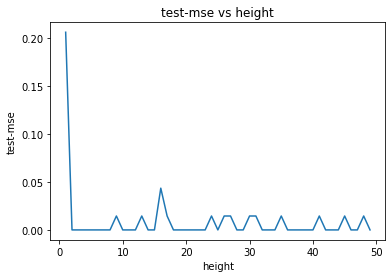

In [157]:
print("\n============== SOLVING Q3 ==============\n")
print("\n========= TRAINING STARTED =========\n")

start = time.time()
tree, train, valid, ht = randomize_select_best_height_tree_gini(train, test)
print("Time elapsed  =  {} ms".format(time.time()-start))
print("\n ============= TRAINING FINISHED ============ \n")
print("BEST TREE: height = {}".format(ht))
data_print(tree, train, test, valid)

print("\n============== SOLVED Q3 ==============\n")

In [158]:
print("\n============== SOLVING Q4 ==============\n")
print("[==== BEFORE PRUNING ====] Valid acc: {}, Valid mse: {}, number of nodes = {}".format(get_accuracy(tree, valid)*100, predict(tree, valid)[0], tree.count_node()))
tree.prune(tree, predict(tree, valid)[0], valid)
print("[==== AFTER PRUNING ====] Valid acc: {}, Valid mse: {}, number of nodes = {}\n".format(get_accuracy(tree, valid)*100, predict(tree, valid)[0], tree.count_node()))
data_print(tree, train, test, valid)

print("\n============== SOLVED Q4 ==============\n")



============== SOLVING Q4 ==============

[==== BEFORE PRUNING ====] Valid acc: 100.0, Valid mse: 0.0, number of nodes = 19
[==== AFTER PRUNING ====] Valid acc: 100.0, Valid mse: 0.0, number of nodes = 7

train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0

============== SOLVED Q4 ==============



In [159]:
print("\n============== SOLVING Q5 ==============\n")
print('\n SAVING =====> \n')
print_decision_tree( tree )
print('The image of the graph is saved as [ decision_tree.gv.pdf ]')
print("\n============== SOLVED Q5 ==============\n")


============== SOLVING Q5 ==============


 SAVING =====> 

The image of the graph is saved as [ decision_tree.gv.pdf ]

============== SOLVED Q5 ==============



Information Gain


============== SOLVING Q3 ==============


========= TRAINING STARTED =========

[---- Height 1 -----] train acc: -0.45, train mse: 0.22, test acc: -0.0, test mse: 0.21
[---- Height 2 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 3 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 4 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 5 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 6 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 7 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 8 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 9 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 10 -----] train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0
[---- Height 11 -----] train acc: 97.01, train

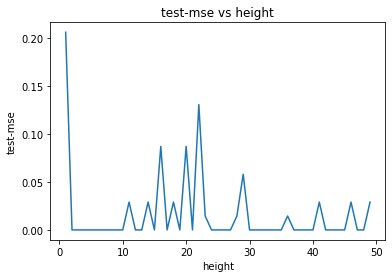

In [160]:
print("\n============== SOLVING Q3 ==============\n")
print("\n========= TRAINING STARTED =========\n")

start = time.time()
tree, train, valid, ht = randomize_select_best_height_tree_infogain(train, test)
print("Time elapsed  =  {} ms".format(time.time()-start))
print("\n ============= TRAINING FINISHED ============ \n")
print("BEST TREE: height = {}".format(ht))
data_print(tree, train, test, valid)

print("\n============== SOLVED Q3 ==============\n")

In [161]:
print("\n============== SOLVING Q4 ==============\n")
print("[==== BEFORE PRUNING ====] Valid acc: {}, Valid mse: {}, number of nodes = {}".format(get_accuracy(tree, valid)*100, predict(tree, valid)[0], tree.count_node()))
tree.prune(tree, predict(tree, valid)[0], valid)
print("[==== AFTER PRUNING ====] Valid acc: {}, Valid mse: {}, number of nodes = {}\n".format(get_accuracy(tree, valid)*100, predict(tree, valid)[0], tree.count_node()))
data_print(tree, train, test, valid)

print("\n============== SOLVED Q4 ==============\n")


============== SOLVING Q4 ==============

[==== BEFORE PRUNING ====] Valid acc: 100.0, Valid mse: 0.0, number of nodes = 25
[==== AFTER PRUNING ====] Valid acc: 100.0, Valid mse: 0.0, number of nodes = 7

train acc: 100.0, train mse: 0.0, test acc: 100.0, test mse: 0.0

============== SOLVED Q4 ==============



In [142]:
print("\n============== SOLVING Q5 ==============\n")
print('\n SAVING =====> \n')
print_decision_tree( tree )
print('The image of the graph is saved as [ decision_tree.gv.pdf ]')
print("\n============== SOLVED Q5 ==============\n")


============== SOLVING Q5 ==============


 SAVING =====> 

The image of the graph is saved as [ decision_tree.gv.pdf ]

============== SOLVED Q5 ==============

